In [279]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind

pd.set_option('display.max_rows', 50) # показывать больше строк
pd.set_option('display.max_columns', 50) # показывать больше колонок

cacao = pd.read_csv('cacao_flavors.csv')


### Fields legend:

bar_id               ID батончика в базе данных
company              название компании, изготовившей батончик.
specific_origin      точное место происхождения какао-бобов.
ref                  числовое значение, показывающее, как давно ревью было добавлено в базу.
                     Чем выше значение, тем более свежее ревью.
review_date          год публикации рецензии.
сocoa_percent        процент какао в шоколаде.
company_location     страна, в которой произведён шоколадный батончик.
rating               оценка батончика фокус-группой.
bean_type            вид какао-бобов, используемых в батончике.
broad_origin         название региона, где были выращены какао-бобы.

# 1. Pre Processing

In [280]:
print(cacao.head(10))
cacao.info()

cacao.columns = ['bar_id', 'company', 'specific_origin', 'ref', 'review_date',
       'cocoa_percent', 'company_location', 'rating', 'bean_type', 'broad_origin']

   Bar id Company \n(Maker-if known) Specific Bean Origin\nor Bar Name   REF  \
0       1                   A. Morin                       Agua Grande  1876   
1       2                   A. Morin                             Kpime  1676   
2       3                   A. Morin                            Atsane  1676   
3       4                   A. Morin                             Akata  1680   
4       5                   A. Morin                            Quilla  1704   
5       6                   A. Morin                          Carenero  1315   
6       7                   A. Morin                              Cuba  1315   
7       8                   A. Morin                      Sur del Lago  1315   
8       9                                               Puerto Cabello  1319   
9      10                   A. Morin                           Pablino  1319   

   Review\nDate Cocoa\nPercent Company\nLocation  Rating Bean\nType  \
0          2016            63%            France

In [281]:
def object_field_info(dataframe, column_name, min_repeats=10):
    ''' getting amount of null and most common values '''

    dataframe[column_name] = dataframe[column_name].apply(lambda x: None if type(x) == str and x.strip() == '' else x)
    print('\nValue counts:', pd.DataFrame(dataframe[column_name].value_counts()))
    print('\nUnique values:', dataframe[column_name].nunique())
    print("\nAppeared more then {} times:".format(min_repeats),
          (dataframe[column_name].value_counts()>min_repeats).sum())
    print('\nGeneral info:')
    dataframe.loc[:, [column_name]].info()

def empty_to_none(dataframe, column_name):
    ''' replace empty strings with None'''
    return dataframe[column_name].astype(str).apply(lambda x: None if type(x) == str and x.strip() == '' else x)

def fix_countries(x):
    if pd.isnull(x):
        return x
    if x == 'nan':
        return None
    x = x.replace(' ', '')
    x = x.replace('/', ',') # Venezuela/ Ghana
    x = x.replace('&', ',')
    if '(' in x:
        x = x[:x.find('(')] #Peru(SMartin,Pangoa,nacional)
    x = x.replace('Guat.', 'Guatemala')

    if 'Ven' in x and 'Venezuela' not in x:
        x = x.replace('Venez', 'Venezuela') #Venez,Africa,Brasil,Peru,Mex
        x = x.replace('Ven,', 'Venezuela,') #Ven, Trinidad, Ecuador
        x = x.replace('Ven.', 'Venezuela') #Ven., Trinidad, Mad.
        if 'Ven' in x and 'Venezuela' not in x:
            x = x.replace('Ven', 'Venezuela')

    x = x.replace('Dom.Rep.', 'DomincanRepublic')
    x = x.replace('DR', 'DomincanRepublic')
    x = x.replace('Dom.Rep', 'DomincanRepublic')
    x = x.replace('D.R.', 'DomincanRepublic')
    x = x.replace('DominicanRep.', 'DomincanRepublic')
    x = x.replace('Domin.Rep', 'DomincanRepublic')
    x = x.replace('Domin.Re', 'DomincanRepublic')

    if 'Jam' in x and 'Jamaica' not in x:
        x = x.replace('Jam', 'Jamaica')

    if 'Mad.' in x and 'Madagascar' not in x:
        x = x.replace('Mad.', 'Madagascar')
    elif 'Mad' in x and 'Madagascar' not in x:
        x = x.replace('Mad', 'Madagascar')
    elif 'Ma' in x and 'Madagascar' not in x:
        x = x.replace('Ma', 'Madagascar')

    if 'Hait' in x and 'Haiti' not in x:
        x = x.replace('Hait', 'Haiti')

    if 'Per' in x and 'Peru'  not in x:
        x = x.replace('Per', 'Peru')

    x = x.replace('Nic.', 'Nicaragua')

    x = x.replace('Gre.', 'Grenada')

    x = x.replace('PNG', 'PapuaNewGuinea')

    if 'Mex' in x and 'Mexico' not in x:
        x = x.replace('Mex', 'Mexico')

    x = x.replace('Haw.', 'Hawaii')

    x = x.replace('Ecuad.', 'Ecuador')
    x = x.replace('Ecu.', 'Ecuador')

    return x

def get_boxplot_by_rating(column):
    fig, ax = plt.subplots(figsize = (14, 4))
    sns.boxplot(x=column, y='rating',
                data=cacao.loc[cacao.loc[:, column].isin(cacao.loc[:, column].value_counts().index[:10])],
               ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

def get_stat_dif(column):
    cols = cacao.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(cacao.loc[cacao.loc[:, column] == comb[0], 'rating'], 
                        cacao.loc[cacao.loc[:, column] == comb[1], 'rating']).pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break

## Primary Analysis (per field)

### bar_id

1795


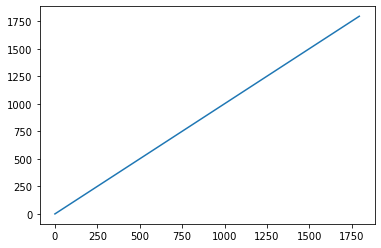

In [282]:
print(cacao.bar_id.nunique())
plt.plot(cacao.bar_id)
cacao.drop(['bar_id'], inplace = True, axis = 1)   # we do not need this column for analysis

### company

In [283]:
pd.DataFrame(cacao.company.value_counts())
object_field_info(cacao, 'company')


Value counts:             company
Soma             45
Fresco           26
Bonnat           26
Pralus           25
Domori           22
...             ...
Hachez            1
ENNA              1
Pinellas          1
Indaphoria        1
Monarque          1

[407 rows x 1 columns]

Unique values: 407

Appeared more then 10 times: 30

General info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1795 entries, 0 to 1794
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   company  1696 non-null   object
dtypes: object(1)
memory usage: 14.1+ KB


### specific_origin

In [284]:
pd.DataFrame(cacao.specific_origin.value_counts())
object_field_info(cacao, 'specific_origin')


Value counts:                          specific_origin
Madagascar                            55
Peru                                  44
Ecuador                               39
Dominican Republic                    33
Venezuela                             21
...                                  ...
Selvagem, Jari                         1
La Bahia, w/ cane juice                1
single estate                          1
Namau Village                          1
Sambirano, 2009                        1

[1012 rows x 1 columns]

Unique values: 1012

Appeared more then 10 times: 15

General info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1795 entries, 0 to 1794
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   specific_origin  1737 non-null   object
dtypes: object(1)
memory usage: 14.1+ KB


### ref

count    1795.000000
mean     1035.904735
std       552.886365
min         5.000000
25%       576.000000
50%      1069.000000
75%      1502.000000
max      1952.000000
Name: ref, dtype: float64

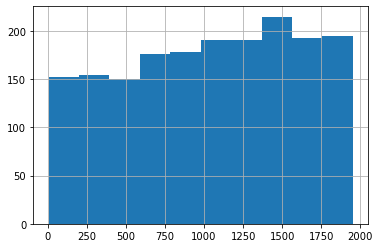

In [285]:
cacao.ref.hist()
cacao.ref.describe()

### review_date

count    1795.000000
mean     2012.325348
std         2.927210
min      2006.000000
25%      2010.000000
50%      2013.000000
75%      2015.000000
max      2017.000000
Name: review_date, dtype: float64

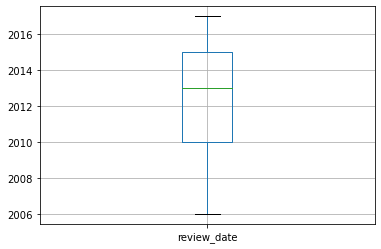

In [286]:
#cacao.review_date.hist()
cacao.boxplot(column=['review_date'])
cacao.review_date.describe()

### cocoa_percent

count    1795.000000
mean       75.932312
std        44.475981
min        42.000000
25%        70.000000
50%        70.000000
75%        75.000000
max       682.000000
Name: cocoa_percent, dtype: float64

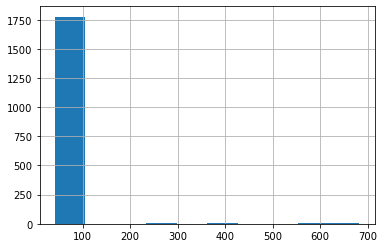

In [287]:
cacao.cocoa_percent
cacao.cocoa_percent = cacao.cocoa_percent.apply(lambda x: float(x.replace('%', '')))

cacao.cocoa_percent.hist()
cacao.cocoa_percent.describe()

70.0 5.0 62.5 77.5


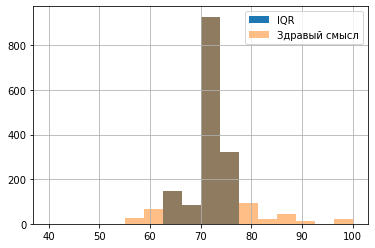

In [288]:
median = cacao.cocoa_percent.median()
IQR = cacao.cocoa_percent.quantile(0.75) - cacao.cocoa_percent.quantile(0.25)
print(median, IQR, median - 1.5*IQR, median + 1.5*IQR)
cacao.cocoa_percent.loc[cacao.cocoa_percent.between(median - 1.5*IQR, median + 1.5*IQR)].hist(bins = 16
                                                                                              , range = (40, 100),
                                                                                             label = 'IQR')
cacao.cocoa_percent.loc[cacao.cocoa_percent <= 100].hist(alpha = 0.5, bins = 16, range = (40, 100),
                                                        label = 'Здравый смысл')
plt.legend();

In [289]:
cacao = cacao.loc[cacao.cocoa_percent <= 100]

### company_location

In [290]:
cacao.company_location
object_field_info(cacao, 'company_location')


Value counts:                 company_location
U.S.A.                       756
France                       155
Canada                       124
U.K.                          94
Italy                         63
...                          ...
Martinique                     1
Wales                          1
Philippines                    1
Russia                         1
Czech Republic                 1

[60 rows x 1 columns]

Unique values: 60

Appeared more then 10 times: 22

General info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1776 entries, 0 to 1794
Data columns (total 1 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   company_location  1776 non-null   object
dtypes: object(1)
memory usage: 27.8+ KB


### rating

In [291]:
cacao.rating


0       11.50
1        2.75
3        3.50
4        3.50
5        2.75
        ...  
1790     3.75
1791     3.00
1792     3.50
1793     3.25
1794     3.00
Name: rating, Length: 1776, dtype: float64

count    1776.000000
mean        3.425816
std         1.759007
min         1.000000
25%         3.000000
50%         3.250000
75%         3.500000
max        19.750000
Name: rating, dtype: float64

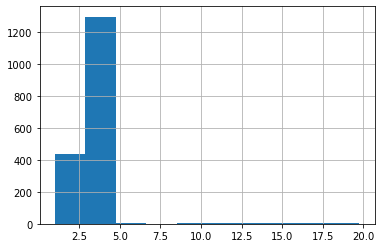

In [292]:
cacao.rating.hist()
cacao.rating.describe()

25-й перцентиль: 3.0, 75-й перцентиль: 3.5, IQR: 0.5,  Границы выбросов: [2.25, 4.25].


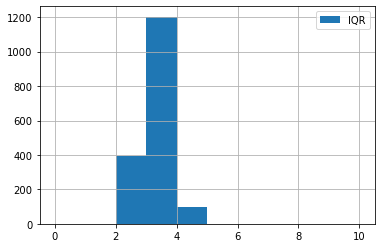

In [293]:
median = cacao.rating.median()
IQR = cacao.rating.quantile(0.75) - cacao.rating.quantile(0.25)
perc25 = cacao.rating.quantile(0.25)
perc75 = cacao.rating.quantile(0.75)
print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75)
      , "IQR: {}, ".format(IQR),"Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))
cacao.rating.loc[cacao.rating.between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)].hist(bins = 10, range = (0, 10),
                                                                                             label = 'IQR')
plt.legend();

In [294]:
cacao = cacao.loc[cacao.rating.between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)]

### bean_type

In [295]:
cacao.bean_type = empty_to_none(cacao, 'bean_type')
cacao.bean_type = cacao.bean_type.apply(lambda x: None if pd.isnull(x) else None if x == 'nan'
                      else x if '(' not in x else x[:x.find('(')].strip())

In [296]:
object_field_info(cacao, 'bean_type')



Value counts:                          bean_type
Trinitario                     405
Forastero                      179
Criollo                        165
Criollo, Trinitario             37
Blend                           36
Trinitario, Criollo              9
Nacional                         5
Matina                           3
Beniano                          3
EET                              3
Criollo, Forastero               2
Trinitario, Forastero            2
Amazon mix                       2
Amazon, ICS                      2
Criollo, +                       1
Trinitario, TCGA                 1
Forastero, Trinitario            1
CCN51                            1
Blend-Forastero,Criollo          1
Trinitario, Nacional             1
Amazon                           1

Unique values: 21

Appeared more then 10 times: 5

General info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1690 entries, 1 to 1794
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
--- 

### broad_origin


In [297]:
cacao.broad_origin = empty_to_none(cacao, 'broad_origin')
object_field_info(cacao, 'broad_origin') 



Value counts:                           broad_origin
Venezuela                          202
Ecuador                            179
Peru                               159
Madagascar                         138
Dominican Republic                 135
...                                ...
Indonesia, Ghana                     1
Peru, Ecuador, Venezuela             1
Ven, Trinidad, Ecuador               1
Ecuador, Costa Rica                  1
Martinique                           1

[97 rows x 1 columns]

Unique values: 97

Appeared more then 10 times: 25

General info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1690 entries, 1 to 1794
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   broad_origin  1631 non-null   object
dtypes: object(1)
memory usage: 26.4+ KB


In [298]:
cacao.broad_origin = cacao.broad_origin.apply(fix_countries).sort_values()


In [299]:
object_field_info(cacao, 'broad_origin')  



Value counts:                                   broad_origin
Venezuela                                  202
Ecuador                                    179
Peru                                       160
Madagascar                                 138
DominicanRepublic                          135
...                                        ...
Ghana,DomincanRepublic                       1
DomincanRepublic,Madagascar                  1
Africa,Carribean,C.Am.                       1
Gabon                                        1
Peru,Madagascar,DomincanRepublic             1

[93 rows x 1 columns]

Unique values: 93

Appeared more then 10 times: 25

General info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1690 entries, 1 to 1794
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   broad_origin  1630 non-null   object
dtypes: object(1)
memory usage: 26.4+ KB


# 2. Correlation analysis (primary)
## Numerical

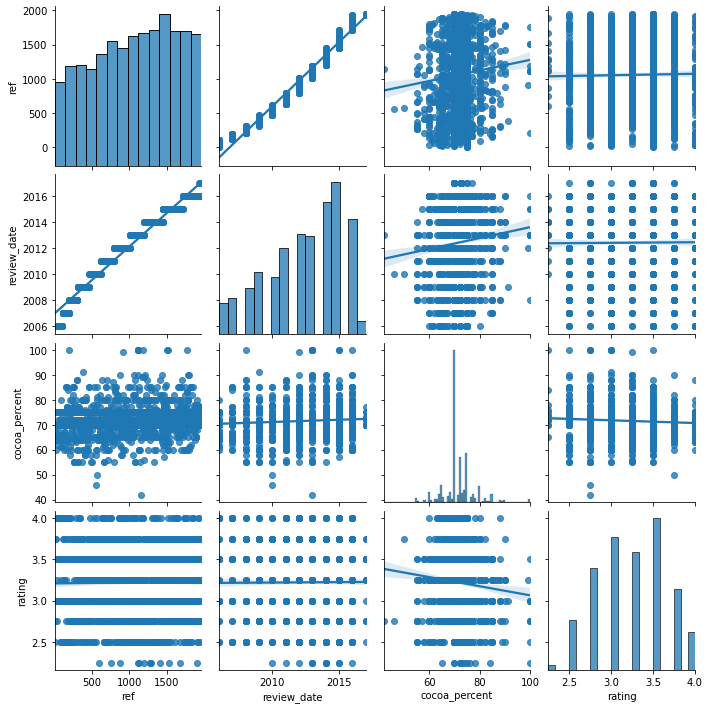

In [300]:
sns.pairplot(cacao, kind = 'reg')

In [301]:
cacao.corr()


,ref,review_date,cocoa_percent,rating
ref,1.000000,0.984913,0.083765,0.016189
review_date,0.984913,1.000000,0.086523,0.006703
cocoa_percent,0.083765,0.086523,1.000000,-0.078156
rating,0.016189,0.006703,-0.078156,1.000000


## Nominative

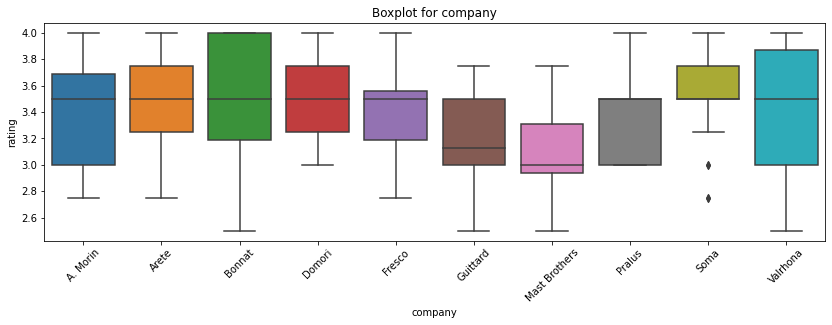

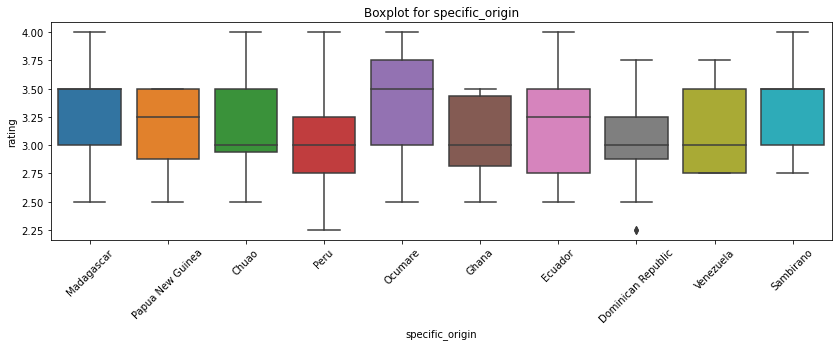

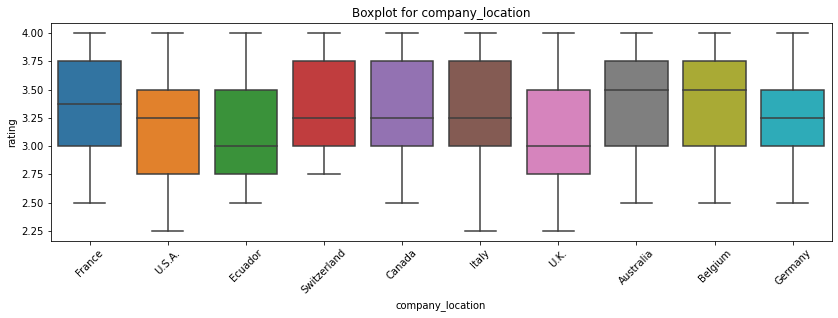

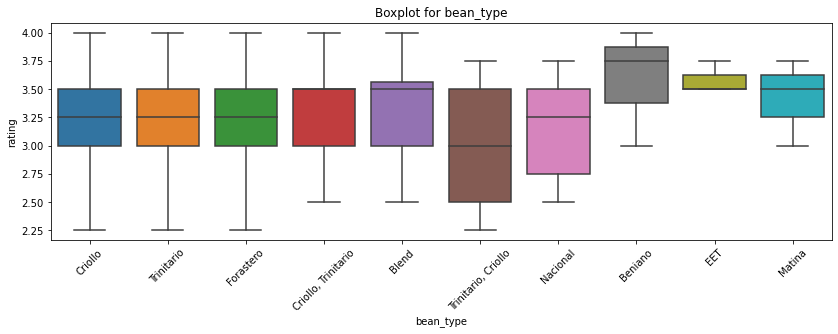

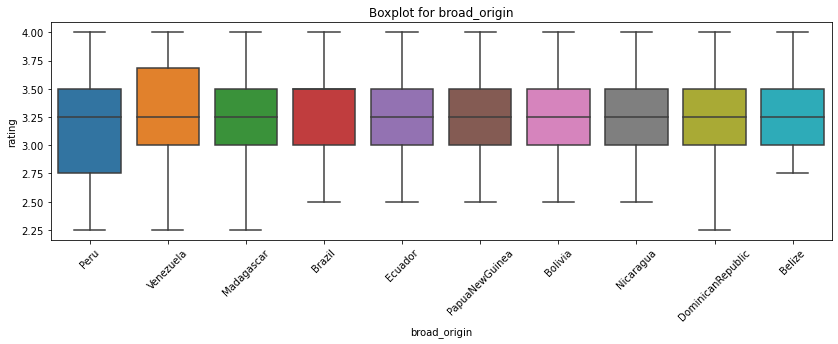

In [302]:
for col in ['company', 'specific_origin', 'company_location', 'bean_type', 'broad_origin']:
    get_boxplot_by_rating(col)

In [303]:
for col in ['company', 'specific_origin', 'company_location', 'bean_type', 'broad_origin']:
    get_stat_dif(col)

Найдены статистически значимые различия для колонки company
Найдены статистически значимые различия для колонки specific_origin
Найдены статистически значимые различия для колонки company_location


# 3. Result

In [305]:
cacao_for_model = cacao.loc[:, ['company', 'specific_origin', 'company_location', 'review_date', 'cocoa_percent']]
cacao_for_model.head()

,company,specific_origin,company_location,review_date,cocoa_percent
1,A. Morin,Kpime,France,2015,70.0
3,A. Morin,Akata,France,2015,70.0
4,A. Morin,Quilla,France,2015,70.0
5,A. Morin,Carenero,France,2014,70.0
6,A. Morin,Cuba,France,2014,70.0
